In [1]:
import pandas as pd

import search
import visualize

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
docs_df = pd.read_parquet("related_large_set.pq")
texts = docs_df.text.tolist()
texts = [text.replace(";", " ") for text in texts]

In [3]:
engine = search.SimpleSearcheEngine()
engine.compile_index(texts, docs_df.url.tolist(), 0.01)

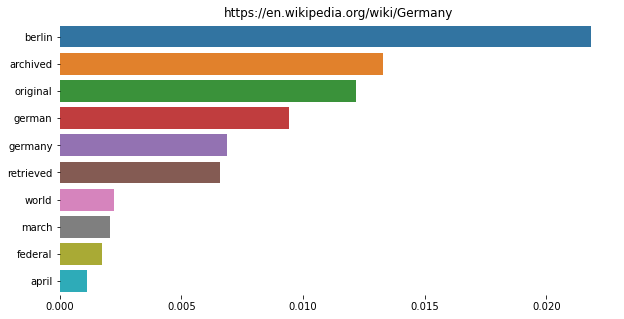

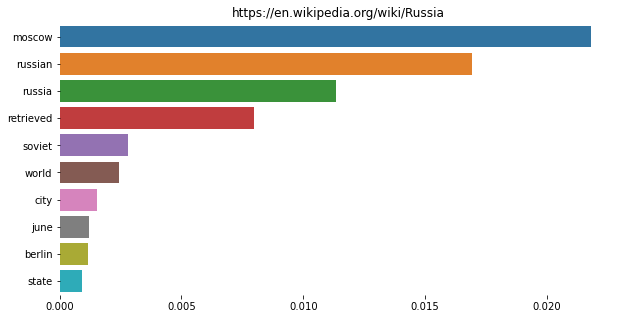

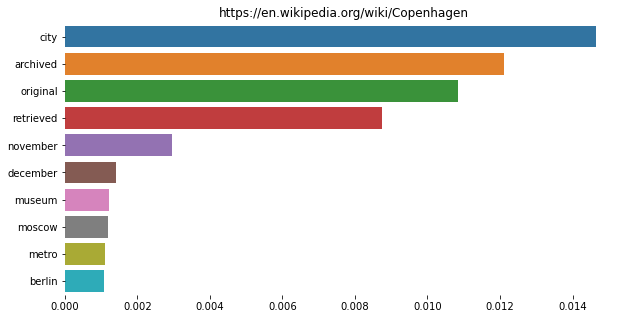

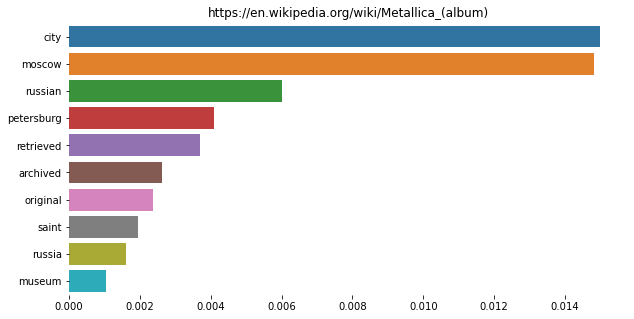

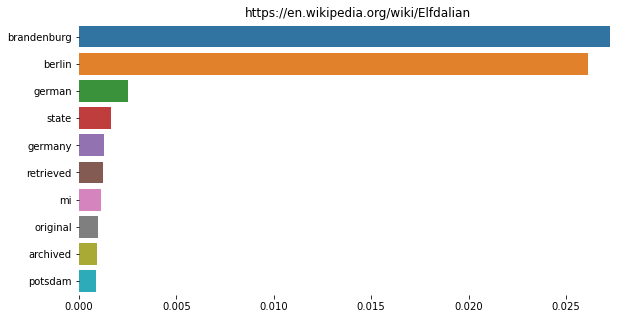

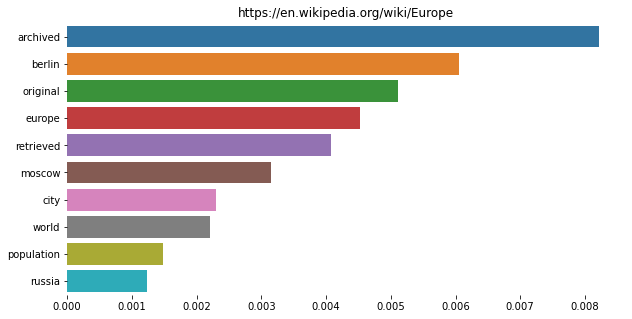

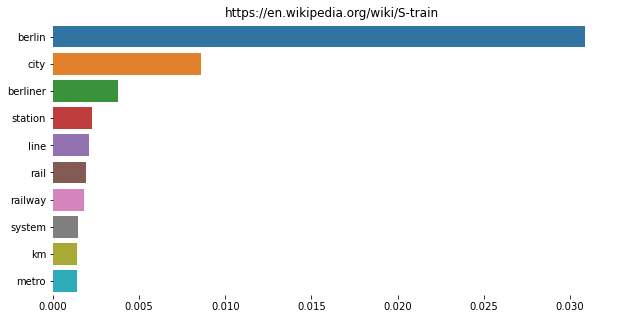

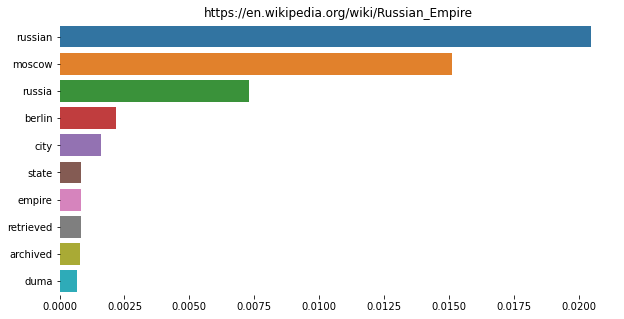

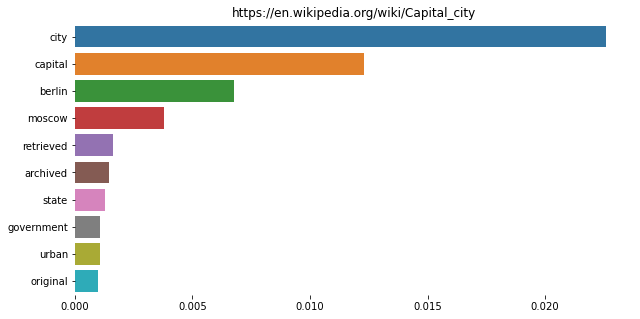

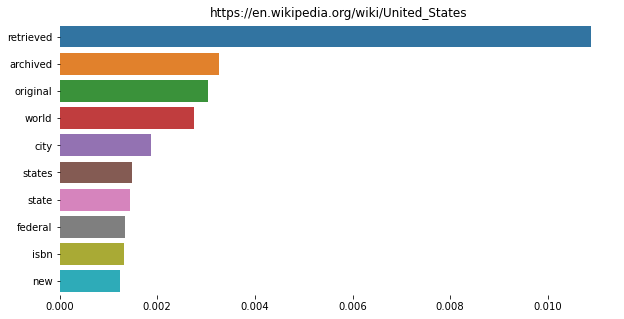

In [4]:
urls = ["https://en.wikipedia.org/wiki/Berlin", "https://en.wikipedia.org/wiki/Moscow"]
queries = [search.wiki_page_from_url_to_content_text(url) for url in urls]

scores_df = engine.get_scores_dataframe_from_queries(queries, top_n=10)
visualize.visualize_top_scores(scores_df, 10)